In [1]:
import json as json
import os
import pathlib as pl
from datetime import datetime
from gc import collect
from os import mkdir, path, system

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from numpy import array, meshgrid, ones
from numpy.linalg import norm
from PIL import Image
from scipy.spatial.transform import Rotation
from tqdm import tqdm

from calc_catenary_from_ext_points import get_coor_marker_points_ideal_catenary

gain = 1.5
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]

In [2]:
for v in pl.Path( "./plots" ).glob( '*' ):
	if datetime.fromtimestamp( path.getctime( v ) ).date() >= datetime.fromisocalendar( 2024, 37, 2 ).date():
		print( str( v ).split( '//' )[ -1 ], end = '\t' )
		print( datetime.fromtimestamp( path.getctime( v ) ), end = '\t' )
		try:
			record = pd.read_csv( f'{v}/logs.txt', sep = '\t' ).shape[ 0 ]
			with open( f'{v}/config.json' ) as f:
				conf = json.load( f )
		except:
			print( 'unable to read' )
			continue
		planned = array( conf[ 'target_trajectory' ] ).shape[ 0 ] // 2
		print( f'{record=}\t{planned=}\t{record == planned}' )

plots\robot_1724851485	2024-09-12 22:05:01.437115	record=399	planned=12	False
plots\three_robots_chain_1725264976	2024-09-12 22:05:01.853236	record=299	planned=300	False
plots\three_robots_chain_1725268112	2024-09-12 22:05:01.928170	record=299	planned=300	False
plots\three_robots_chain_1725274451	2024-09-12 22:05:02.010784	record=299	planned=300	False
plots\three_robots_chain_1725278516	2024-09-12 22:05:02.088836	record=299	planned=300	False
plots\three_robots_chain_1725525073	2024-09-12 22:05:02.166874	record=599	planned=600	False
plots\three_robots_chain_1725534896	2024-09-12 22:05:02.353150	record=599	planned=600	False
plots\three_robots_chain_1726033948	2024-09-11 07:52:28.967991	record=2000	planned=2000	True
plots\three_robots_chain_1726033954	2024-09-12 22:05:02.508750	record=2000	planned=2000	True
plots\three_robots_chain_1726033959	2024-09-12 22:05:02.522252	record=2000	planned=2000	True
plots\three_robots_chain_1726151643	2024-09-12 16:34:03.025139	record=2000	planned=2000	Tru

In [3]:
folder = pl.Path( './plots/three_robots_chain_with_fixed_end_1726429003' )
# folder = pl.Path( './plots/three_robots_chain_with_fixed_end_1726242029' )
# folder = pl.Path( './plots/three_robots_chain_1726157070' )
id = str( folder ).split( '_' )[ -1 ]
data = pd.read_csv( f'{folder}/logs.txt', sep = '\t' )
with open( f'{folder}/config.json' ) as f:
	conf = json.load( f )
data[ 'time' ] = [ i * conf[ 'time_step' ] for i in data.index ]

In [4]:
def disp( d: dict, prefix: str = '' ):
	for k, v in d.items():

		if isinstance( v, dict ):
			print( prefix + k + ':' )
			disp( v, prefix + '\t' )
			continue

		if isinstance( v, list ):
			if len( v ) > 0 and isinstance( v[ 0 ], dict ):
				print( prefix + k + ':' )
				disp( { str( i ): e for i, e in enumerate( v ) }, prefix + '\t' )
				continue

			l = array( v ).shape
			print( prefix + k + ':', v if sum( l ) < 10 else l )
			continue

		print( prefix + k + ':', v )


disp( conf )

model_dynamics: three_robots_chain_with_fixed_end
time_step: 0.01
kwargs:
	weight: [0.0, 0.0, 112.81500000000001]
	buoyancy: [0.0, 0.0, -120.0]
	center_of_mass: [0.0, 0.0, 0.0]
	center_of_volume: [0.0, 0.0, -0.02]
	inverted_inertial_matrix: (6, 6)
	hydrodynamic_matrix: (6, 6)
state: (48,)
actuation: (18,)
record: True
previous_states: (1, 48)
previous_actuations: (1, 18)
model: None
horizon: 25
target_trajectory: (4000, 1, 24)
objective: three_robot_chain_objective
time_steps_per_actuation: 25
guess_from_last_solution: True
tolerance: 0.0001
max_iter: 1000
bounds:
	lb: (18,)
	ub: (18,)
	keep_feasible: (18,)
constraints:
	0:
		fun: constraint_f
		lb: (300,)
		ub: (300,)
		finite_diff_rel_step: None
		finite_diff_jac_sparsity: None
		jac: 2-point
		hess: None
		keep_feasible: False
result_shape: [1, 1, 18]
raw_result: None
result: (1, 1, 18)
pose_weight_matrix: (25, 24, 24)
actuation_derivative_weight_matrix: (1, 18, 18)
objective_weight: 10.0
final_weight: 10.0
predicted_trajectories: [

In [5]:
conf[ 'constraints' ][ 0 ][ 'ub' ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // 25 ]

[3.00001, 3.00001, 3.00001, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 3.0, 3.0, 3.0]

In [6]:
conf[ 'constraints' ][ 0 ][ ('lb') ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // 25 ]

[-inf, -inf, -inf, 0.4, 0.4, 0.4, -inf, -inf, -inf, -inf, -inf, -inf]

In [7]:
data.tail( 10 )

,index,sim_time,step_time,success,C01,C12,C23,D01,D12,D23,...,speed_r0,speed_r1,speed_r2,speed_r3,actuation_r0,actuation_r1,actuation_r2,objective,Unnamed: 25,time
1990,1990,4356.700109,3.863358,True,1.268378,0.802400,2.327565,1.246404,1.382355,0.428709,...,"[0.03523621640392929, -0.006275630943196657, 0...","[0.15247116389238913, 0.7286451183083935, 0.28...","[0.4229778163180242, -0.00976859050987787, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.7906829441567838, 1.4320557889494303, 7.16...","[-78.85963532370712, 28.721566094919282, -56.1...","[-110.12628956093084, 89.49632670584836, 35.61...",6.193057,NaN,19.90
1991,1991,4357.150097,0.406519,True,1.264507,0.794928,2.342570,1.248658,1.384179,0.429628,...,"[0.029943826989836837, 0.009924816697009502, 0...","[0.08483938689355326, 0.7402099729812412, 0.22...","[0.321917925098791, 0.05103235288999483, -0.27...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-6.230688092936443, 18.615770649799924, 6.490...","[-78.25090746365633, 8.721566094919282, -63.29...","[-117.71654004183642, 69.80216206322218, 50.20...",6.318270,NaN,19.91
1992,1992,4357.591020,0.396587,True,1.259951,0.788130,2.354484,1.251081,1.386046,0.430404,...,"[0.021636485737522214, 0.041194201212665815, 0...","[0.017500786877274827, 0.7343992093853225, 0.1...","[0.21389181347094183, 0.09499129229706142, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-9.670232292677941, 35.797091666357815, 5.815...","[-77.64214947498375, -11.278433905080718, -70....","[-125.30675298660576, 50.10797478410137, 64.80...",6.747332,NaN,19.92
1993,1993,4361.749608,4.114035,True,1.254842,0.782020,2.362944,1.253599,1.388025,0.431019,...,"[0.016633802450392723, 0.05519507213096205, -0...","[-0.049269763306930905, 0.7111185571083897, 0....","[0.11022518943118075, 0.1229307733876445, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-5.842747898012719, 15.797091666357815, 6.553...","[-76.71903339589477, -31.278433905080718, -77....","[-119.86715492136312, 31.461877323928697, 72.7...",6.678516,NaN,19.93
1994,1994,4362.190556,0.397011,True,1.249166,0.776557,2.367803,1.256206,1.390201,0.431460,...,"[0.014947332714477842, 0.05183377701449047, -0...","[-0.11547026166467403, 0.6702732344126024, 0.0...","[0.010933371314822065, 0.13476395143769665, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.0152635033474984, -4.202908333642185, 7.29...","[-75.79591731680578, -51.27843390508072, -84.1...","[-114.42755685612049, 12.81577986375602, 80.74...",7.216020,NaN,19.94
1995,1995,4367.203445,4.970216,True,1.243058,0.771703,2.369179,1.258852,1.392598,0.431725,...,"[0.013990094283202957, 0.04775641188469733, -0...","[-0.16473054451603675, 0.6197728807166732, -0....","[-0.07128484100505465, 0.13025626853662195, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.170912866988757, -5.003626262939331, 7.365...","[-56.08238433729693, -62.09763130753068, -67.6...","[-94.42755685612049, -5.999188234938423, 76.78...",5.257220,NaN,19.95
1996,1996,4367.604687,0.356249,True,1.236800,0.767420,2.367454,1.261442,1.395172,0.431822,...,"[0.013764604864462399, 0.042959089837101984, 9...","[-0.19699113830708134, 0.559565097152712, -0.1...","[-0.13636950009195176, 0.10931913582458462, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.32656223063001555, -5.804344192236478, 7.4...","[-36.368851357788074, -72.91682870998065, -51....","[-74.42755685612049, -24.814156333632866, 72.8...",4.801436,NaN,19.96
1997,1997,4368.007792,0.352128,True,1.230671,0.763669,2.363020,1.263884,1.397877,0.431756,...,"[0.014273392796655727, 0.03743790098764121, 0....","[-0.21219236216811174, 0.4895972009731061, -0....","[-0.18426044991105792, 0.07186348312598158, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5177884057287259, -6.605062121533624, 7.512...","[-16.655318378279215, -83.73602611243061, -34....","[-54.42755685612049, -43.62912443232731, 68.86...",4.711729,NaN,19.97
1998,1998,4368.446156,0.393040,True,1.224946,0.760408,2.356277,1.266085,1.400665,0.431532,...,"[0.015518939548219477, 0.031188984141574935, 0...","[-0.21027432379028776, 0.

In [8]:
n_robots = len(conf['state']) // 12

state_r0 = data[ 'state_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r1 = data[ 'state_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r2 = data[ 'state_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r0['z'] += 1.
state_r1['z'] += 1.
state_r2['z'] += 1.

speed_r0 = data[ 'speed_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r0[ 'l_norm' ] = norm( speed_r0[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r0[ 'a_norm' ] = norm( speed_r0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r1 = data[ 'speed_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r1[ 'l_norm' ] = norm( speed_r1[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r1[ 'a_norm' ] = norm( speed_r1[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r2 = data[ 'speed_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r2[ 'l_norm' ] = norm( speed_r2[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r2[ 'a_norm' ] = norm( speed_r2[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

actuation_r0 = data[ 'actuation_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r1 = data[ 'actuation_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r2 = data[ 'actuation_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)


state_r3 = data[ 'state_r3' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r3[ 'z' ] += 1.
speed_r3 = data[ 'speed_r3' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r3[ 'l_norm' ] = norm( speed_r3[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r3[ 'a_norm' ] = norm( speed_r3[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

n_frames = len( conf[ 'target_trajectory' ] )
traj = array( conf[ 'target_trajectory' ] )[ :n_frames // 2, :, : ]
traj[:, :, 2] += 1.

# Errors

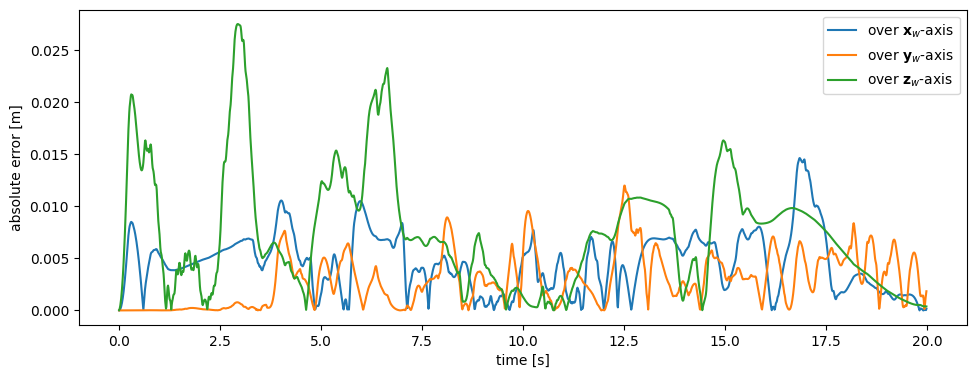

In [9]:
plt.plot( data[ 'time' ], abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] ) )
plt.legend( [ 
		r'over $\mathbf{x}_w$-axis', 
		r'over $\mathbf{y}_w$-axis', 
		r'over $\mathbf{z}_w$-axis' 
		] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'absolute error [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_error.png', dpi = 300 )

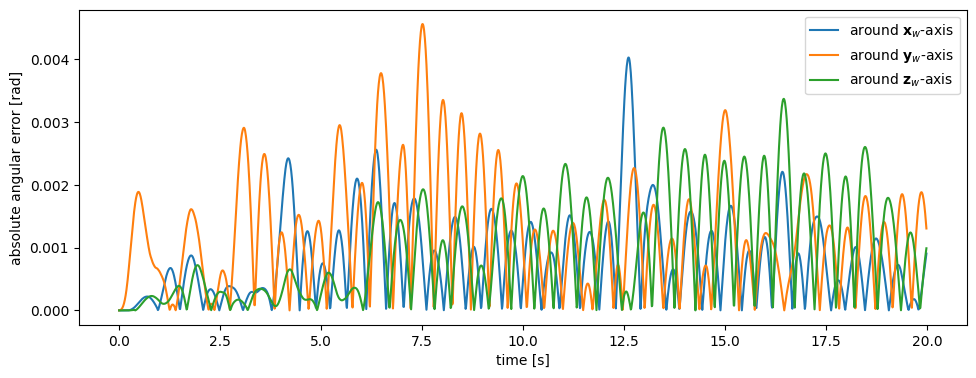

In [36]:
plt.plot( data[ 'time' ], abs( traj[ :data.shape[ 0 ], 0, 3:6 ] - state_r0[ [ 'phi', 'theta', 'psi' ] ] ) )
plt.legend( [ 
		r'around $\mathbf{x}_w$-axis', 
		r'around $\mathbf{y}_w$-axis', 
		r'around $\mathbf{z}_w$-axis' 
		] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'absolute angular error [rad]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_angular_error.png', dpi = 300 )

In [10]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).describe()

,x,y,z
count,2.000000e+03,2.000000e+03,2000.000000
mean,4.586315e-03,2.910055e-03,0.007459
std,2.850037e-03,2.497023e-03,0.005695
min,7.628425e-09,7.040716e-16,0.000013
25%,2.161414e-03,4.961515e-04,0.002938
50%,4.468807e-03,2.591405e-03,0.006746
75%,6.558242e-03,4.634370e-03,0.010303
max,1.462316e-02,1.198123e-02,0.027484


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

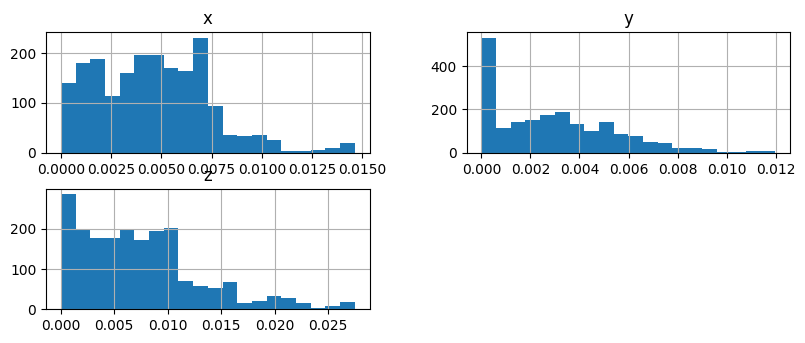

In [11]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).hist( bins = 20 )

<Axes: >

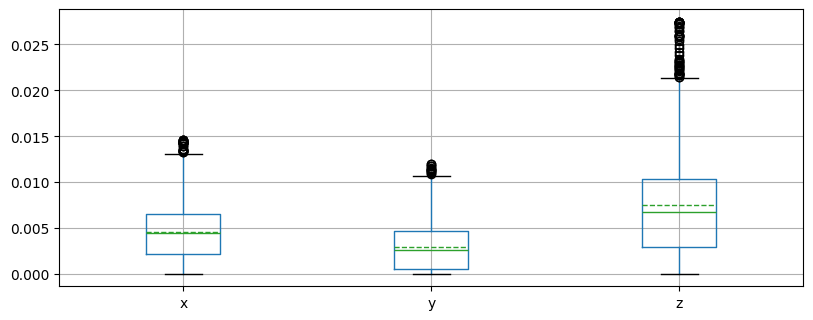

In [12]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).boxplot( meanline = True, showmeans = True )

In [13]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).describe()

,0
count,2000.000000
mean,0.010183
std,0.005314
min,0.000031
25%,0.006051
50%,0.009194
75%,0.013501
max,0.028253


In [40]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, 3:6 ] - state_r0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 ) ).describe()

,0
count,2.000000e+03
mean,2.030457e-03
std,9.307327e-04
min,2.461747e-07
25%,1.419570e-03
50%,1.927139e-03
75%,2.639447e-03
max,5.025170e-03


array([[<Axes: title={'center': '0'}>]], dtype=object)

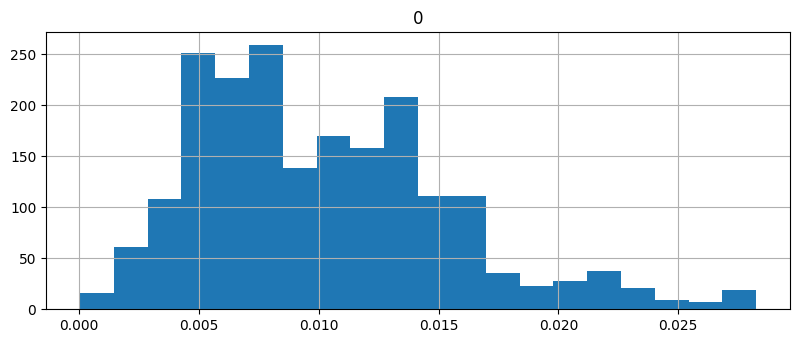

In [14]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).hist( bins = 20 )

<Axes: >

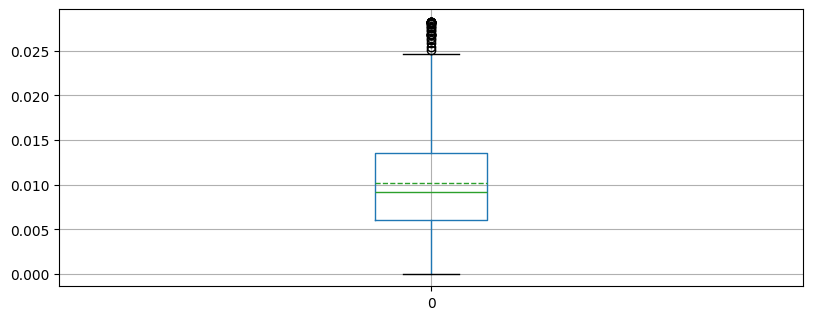

In [15]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).boxplot(
		meanline = True,
		showmeans = True
		)

# Constraints

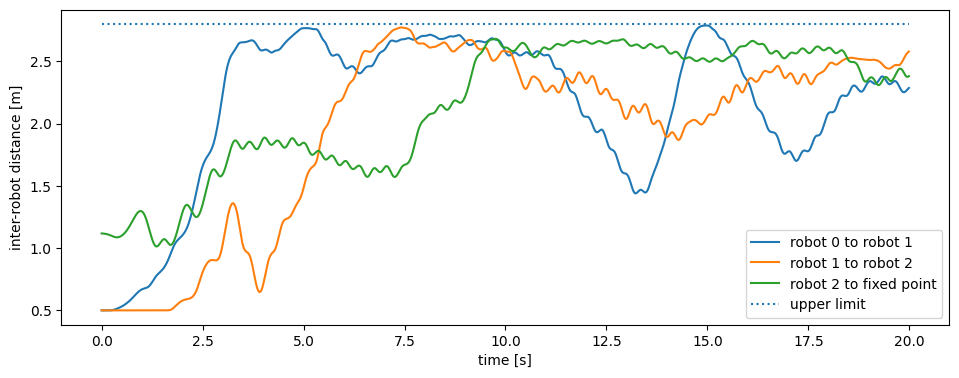

In [16]:
plt.plot( data[ 'time' ], norm( state_r1[ [ 'x', 'y', 'z' ] ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r2[ [ 'x', 'y', 'z' ] ] - state_r1[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r3[ [ 'x', 'y', 'z' ] ] - state_r2[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 2* (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend( [ 
		'robot 0 to robot 1', 
		'robot 1 to robot 2', 
		'robot 2 to fixed point',
		'upper limit' 
		] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_inter_robot_distance.png', dpi = 300 )

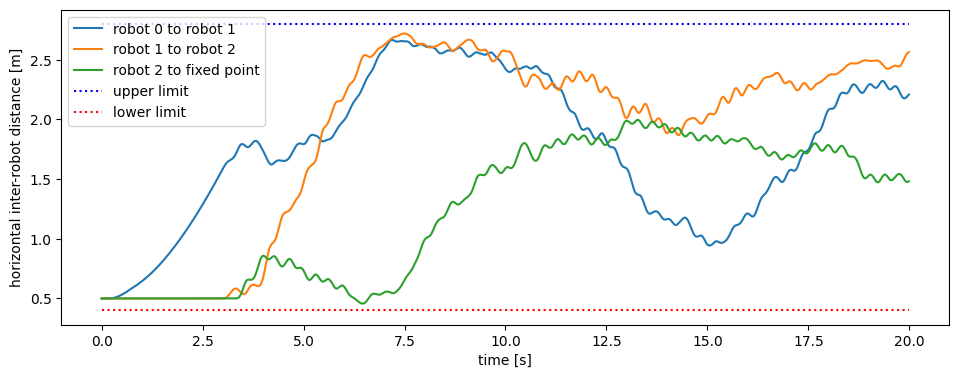

In [17]:
plt.plot( data[ 'time' ], norm( state_r1[ [ 'x', 'y' ] ] - state_r0[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r2[ [ 'x', 'y' ] ] - state_r1[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r3[ [ 'x', 'y' ] ] - state_r2[ [ 'x', 'y' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':', color = 'b' )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'lb' ][ (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':', color = 'r' )
plt.legend(
		[
				'robot 0 to robot 1',
				'robot 1 to robot 2',
				'robot 2 to fixed point', 
				'upper limit',
				'lower limit'
				]
		)
plt.xlabel( 'time [s]' )
plt.ylabel( 'horizontal inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_horizontal_inter_robot_distance.png', dpi = 300 )

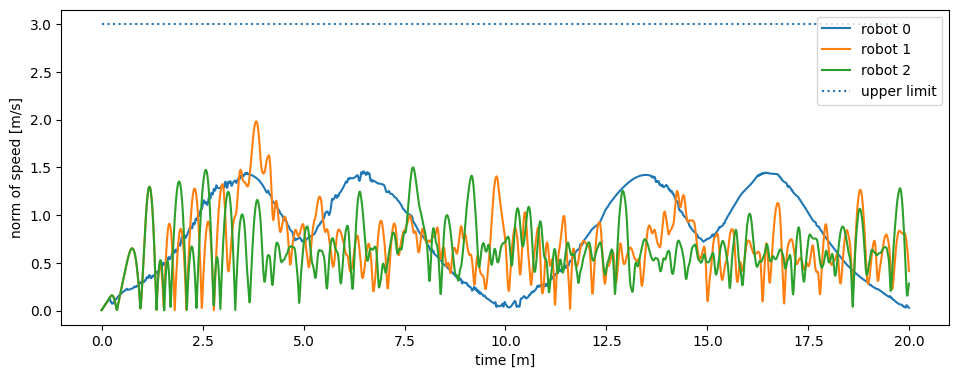

In [18]:
plt.plot( data[ 'time' ], speed_r0[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_r1[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_r2[ 'l_norm' ] )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 3 * (n_robots - 1) ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend( [ 
		'robot 0', 
		'robot 1', 
		'robot 2', 
		'upper limit' 
		] )
plt.xlabel( 'time [m]' )
plt.ylabel( 'norm of speed [m/s]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_robots_speed.png', dpi = 300 )

# States

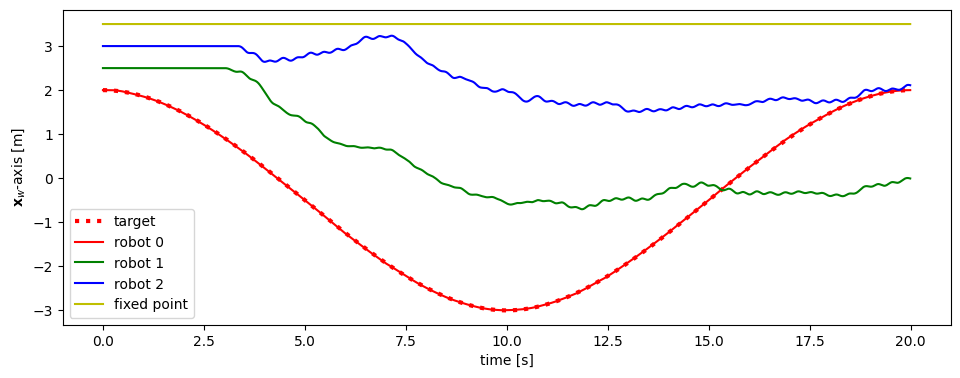

In [19]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 0 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'x' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'x' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'x' ], 'b' )
plt.plot( data[ 'time' ], state_r3[ 'x' ], 'y' )

plt.legend( [ 
		'target', 
		'robot 0', 
		'robot 1', 
		'robot 2', 
		'fixed point' 
		] )
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{x}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_x.png', dpi = 300 )

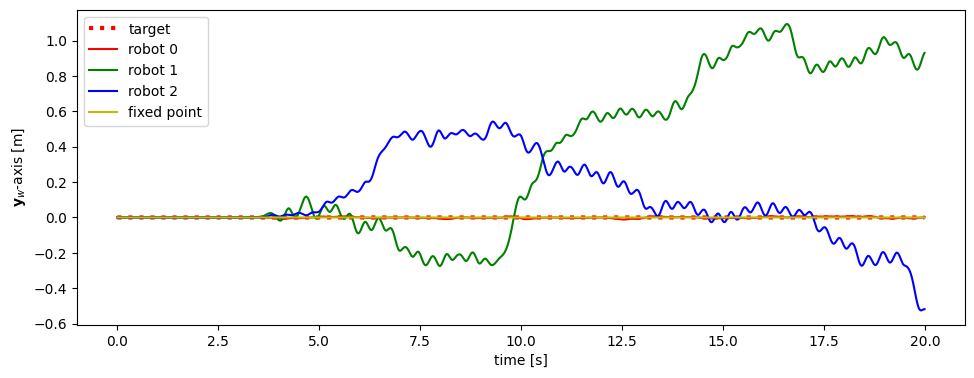

In [20]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 1 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'y' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'y' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'y' ], 'b' )
plt.plot( data[ 'time' ], state_r3[ 'y' ], 'y' )

plt.legend( [ 
		'target', 
		'robot 0', 
		'robot 1', 
		'robot 2', 
		'fixed point' 
		] )
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{y}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_y.png', dpi = 300 )

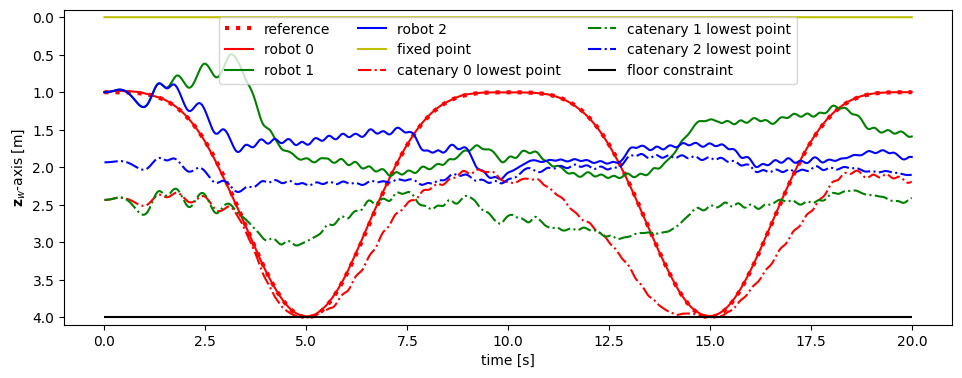

In [21]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 2 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'z' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'z' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'z' ], 'b' )
plt.plot( data[ 'time' ], state_r3[ 'z' ], 'y' )
plt.plot( data[ 'time' ], data[ 'H01' ] + state_r0[ 'z' ], '-.', color = 'r' )
plt.plot( data[ 'time' ], data[ 'H12' ] + state_r1[ 'z' ], '-.', color = 'g' )
plt.plot( data[ 'time' ], data[ 'H23' ] + state_r2[ 'z' ], '-.', color = 'b' )

plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] + 1, 0, data[ 'time' ].max(), 'k' )
plt.ylim(-0.1, 4.1)
plt.legend(
		[
				'reference',
				'robot 0',
				'robot 1',
				'robot 2',
				'fixed point',
				'catenary 0 lowest point',
				'catenary 1 lowest point',
				'catenary 2 lowest point',
				'floor constraint'
				],
		ncol = 3,
		loc='upper center'
		)
plt.gca().invert_yaxis()
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{z}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_pose_z.png', dpi = 300 )

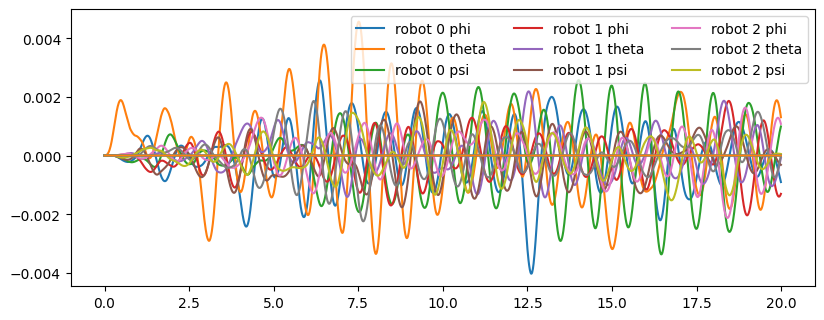

In [22]:
plt.plot(data['time'], state_r0[['phi', 'theta', 'psi']])
plt.plot(data['time'], state_r1[['phi', 'theta', 'psi']])
plt.plot(data['time'], state_r2[['phi', 'theta', 'psi']])
plt.plot(data['time'], state_r3[['phi', 'theta', 'psi']])
plt.legend([
		'robot 0 phi', 
		'robot 0 theta', 
		'robot 0 psi', 
		'robot 1 phi', 
		'robot 1 theta', 
		'robot 1 psi', 
		'robot 2 phi',
		'robot 2 theta',
		'robot 2 psi'
		], ncol= 3)
plt.savefig( f'{folder}/{id}_orientations.png', dpi = 300 )

# Speeds

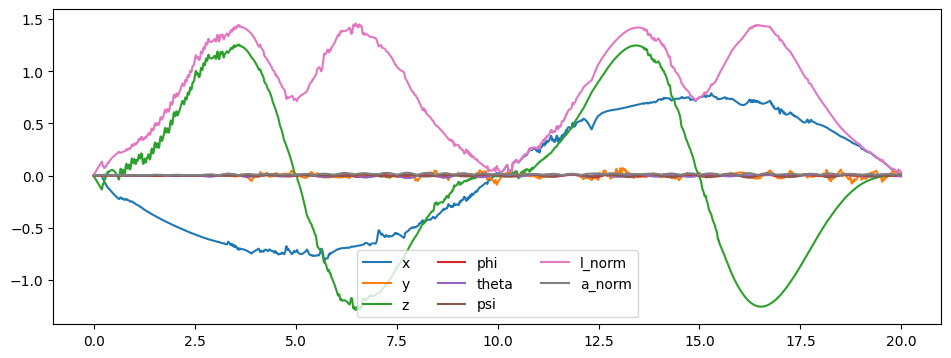

In [23]:
plt.plot( data[ 'time' ], speed_r0 )
plt.legend( speed_r0.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_r0.png', dpi = 300 )

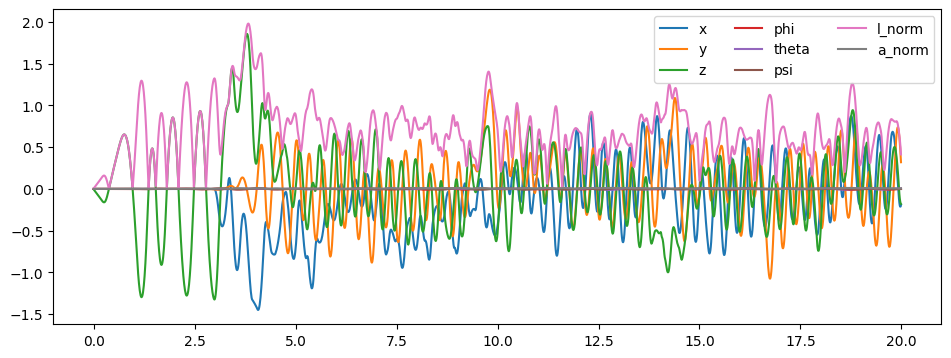

In [24]:
plt.plot( data[ 'time' ], speed_r1 )
plt.legend( speed_r1.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_r1.png', dpi = 300 )

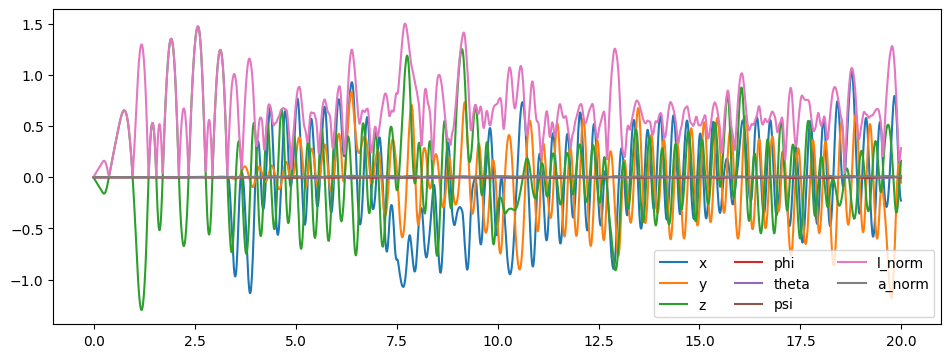

In [25]:
plt.plot( data[ 'time' ], speed_r2 )
plt.legend( speed_r2.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_speed_r2.png', dpi = 300 )

# Actuations

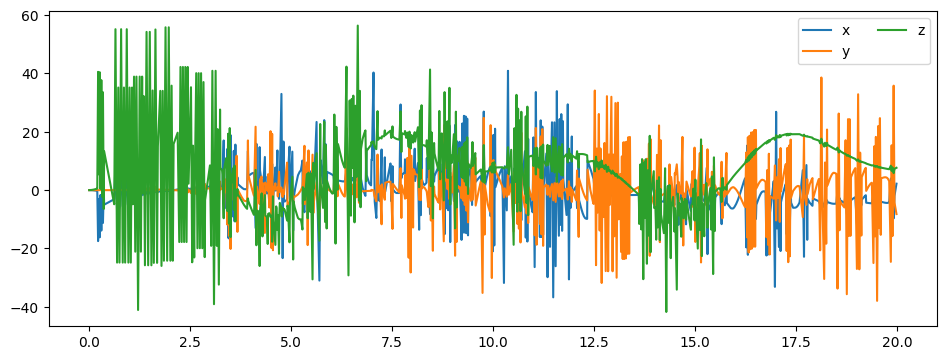

In [38]:
plt.plot( data[ 'time' ], actuation_r0[actuation_r0.columns[:3]] )
plt.legend( actuation_r0.columns[:3], ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_r0.png', dpi = 300 )

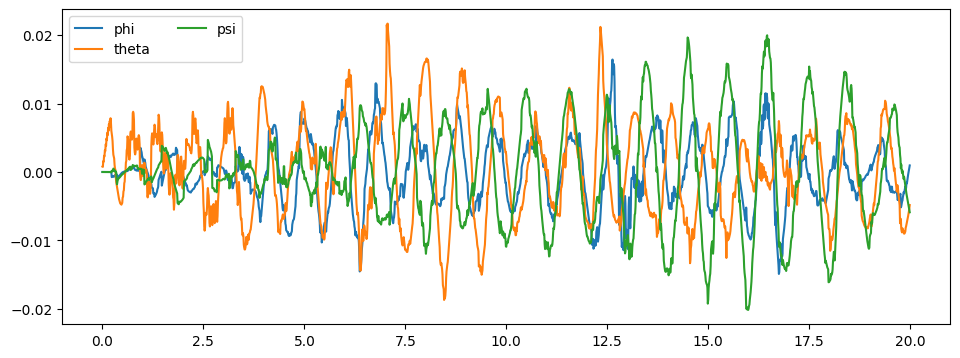

In [39]:
plt.plot( data[ 'time' ], actuation_r0[actuation_r0.columns[3:]] )
plt.legend( actuation_r0.columns[3:], ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_r0.png', dpi = 300 )

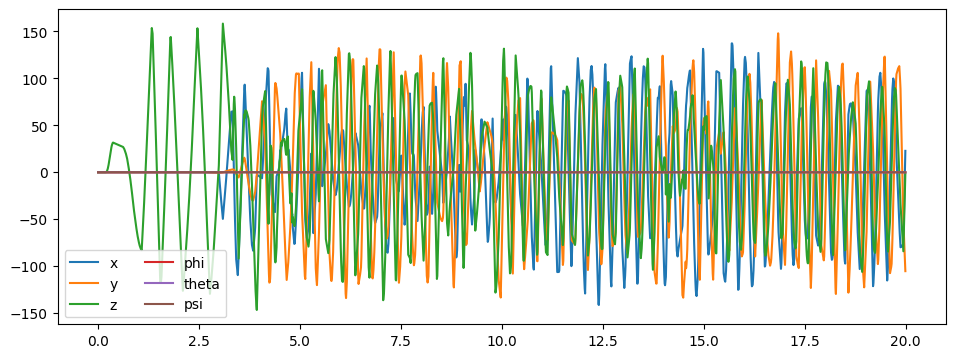

In [27]:
plt.plot( data[ 'time' ], actuation_r1 )
plt.legend( actuation_r1.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_r1.png', dpi = 300 )

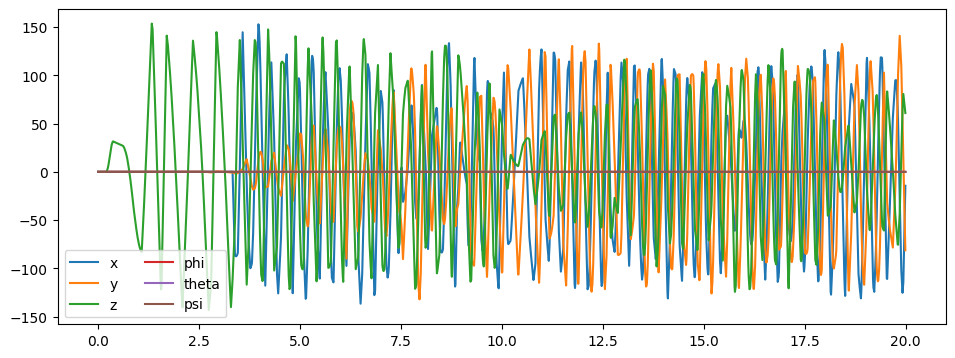

In [28]:
plt.plot( data[ 'time' ], actuation_r2 )
plt.legend( actuation_r2.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_actuation_r2.png', dpi = 300 )

# Time

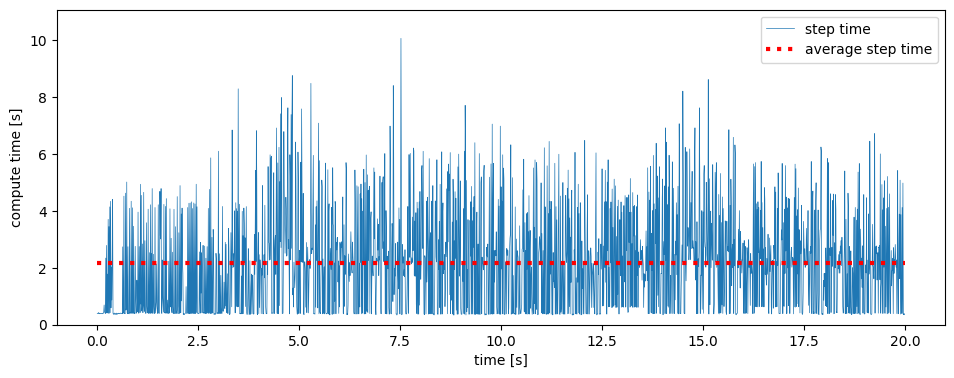

In [29]:
plt.plot( data[ 'time' ], data[ 'step_time' ], linewidth = .5 )
plt.hlines( data.step_time.mean(), 0, data[ 'time' ].max(), linestyles = ':', color = 'r', linewidth = 3 )
plt.ylabel( 'compute time [s]' )
plt.xlabel( 'time [s]' )
plt.gca().set_ylim( 0, data.step_time.max() * 1.1 )
plt.legend( [ 'step time', 'average step time' ] )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/{id}_compute_time.png', dpi = 300 )

In [30]:
data[ 'step_time' ].describe()

count    2000.000000
mean        2.159123
std         1.814292
min         0.337903
25%         0.403316
50%         1.992183
75%         3.270267
max        10.048079
Name: step_time, dtype: float64

<Axes: >

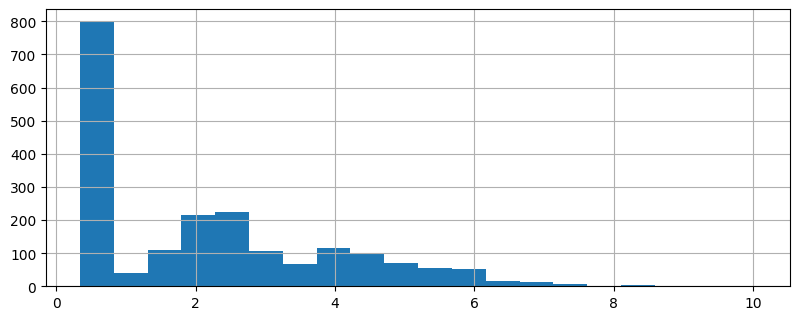

In [31]:
data[ 'step_time' ].hist( bins = 20 )

<Axes: >

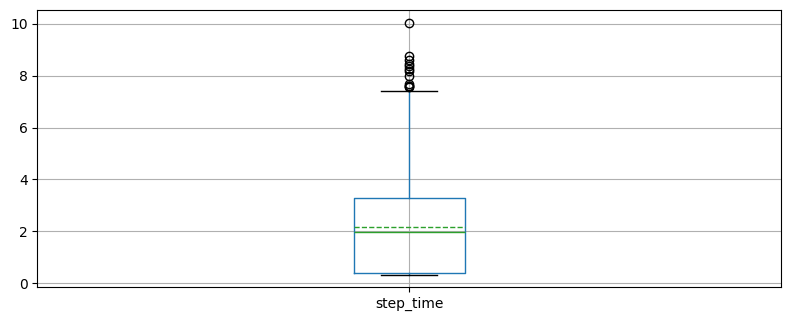

In [32]:
data[ 'step_time' ].to_frame().boxplot( meanline = True, showmeans = True )

In [33]:
def plot( i: int ):
	volume = array( [ [ -3.5, 3.5 ], [ -3.5, 3.5 ], [ -2, 5 ] ] )
	fig = plt.figure( figsize = (10, 10) )
	view = plt.subplot( projection = '3d' )
	view.set_xlabel( "x" )
	view.set_ylabel( "y" )
	view.set_zlabel( "z" )
	view.set_xlim( *volume[ 0 ] )
	view.set_ylim( *volume[ 1 ] )
	view.set_zlim( *volume[ 2 ] )
	view.invert_yaxis()
	view.invert_zaxis()

	inset_view_xz = view.inset_axes( [ .0, .0, .2, .2 ] )
	inset_view_xz.set_xlabel( "x" )
	inset_view_xz.set_ylabel( "z" )
	inset_view_xz.set_xlim( *volume[ 0 ] )
	inset_view_xz.set_ylim( *volume[ 2 ] )
	inset_view_xz.invert_yaxis()

	inset_view_yz = view.inset_axes( [ .8, .0, .2, .2 ] )
	inset_view_yz.set_xlabel( "y" )
	inset_view_yz.set_ylabel( "z" )
	inset_view_yz.set_xlim( *volume[ 1 ] )
	inset_view_yz.set_ylim( *volume[ 2 ] )
	inset_view_yz.invert_xaxis()
	inset_view_yz.invert_yaxis()

	inset_view_xy = view.inset_axes( [ .0, .8, .2, .2 ] )
	inset_view_xy.set_xlabel( "x" )
	inset_view_xy.set_ylabel( "y" )
	inset_view_xy.set_xlim( *volume[ 0 ] )
	inset_view_xy.set_ylim( *volume[ 1 ] )
	inset_view_xy.invert_yaxis()

	target_trajectory = array( conf[ 'target_trajectory' ] )[ :, 0, : ]

	surf_x = [ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ]
	surf_y = volume[ 1 ]
	surf_x, surf_y = meshgrid( surf_x, surf_y )
	surf_z = ones( surf_x.shape ) * conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ]
	view.plot_surface( surf_x, surf_y, surf_z, alpha = 0.1 )
	inset_view_xz.plot(
			[ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)
	inset_view_yz.plot(
			[ volume[ 1 ][ 0 ], volume[ 1 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)

	target_pose = target_trajectory[ i ]
	target_pose[ 2 ] += 1.

	r0 = Rotation.from_euler( 'xyz', state_r0.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r1 = Rotation.from_euler( 'xyz', state_r1.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r2 = Rotation.from_euler( 'xyz', state_r2.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r3 = Rotation.from_euler( 'xyz', state_r3.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r0t = Rotation.from_euler( 'xyz', target_pose[ 3:6 ] ).as_matrix()

	quiver_scale = .25
	view.quiver(
			*state_r0.iloc[ i ].to_numpy()[ :3 ], *(r0 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'red'
			)
	view.quiver(
			*state_r1.iloc[ i ].to_numpy()[ :3 ], *(r1 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'green'
			)
	view.quiver(
			*state_r2.iloc[ i ].to_numpy()[ :3 ],
			*(r2 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'blue'
			)
	view.quiver(
			*state_r3.iloc[ i ].to_numpy()[ :3 ],
			*(r3 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'yellow'
			)
	view.quiver(
			*target_pose[ :3 ], *(r0t @ (quiver_scale * array( [ 1., 0., 0. ] ))), color = 'black'
			)

	inset_view_xz.scatter( state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_xz.scatter( state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_xz.scatter( state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	inset_view_xz.scatter( state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_yz.scatter( state_r0.iloc[ i ].to_numpy()[ 1 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_yz.scatter( state_r1.iloc[ i ].to_numpy()[ 1 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_yz.scatter( state_r2.iloc[ i ].to_numpy()[ 1 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	inset_view_yz.scatter( state_r3.iloc[ i ].to_numpy()[ 1 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_xy.scatter( state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 1 ], color = 'red' )
	inset_view_xy.scatter( state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 1 ], color = 'green' )
	inset_view_xy.scatter( state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 1 ], color = 'blue' )
	inset_view_xy.scatter( state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow' )

	view.plot(
			state_r0[ 'x' ].to_numpy()[ :i ],
			state_r0[ 'y' ].to_numpy()[ :i ],
			state_r0[ 'z' ].to_numpy()[ :i ],
			color = 'red'
			)
	view.plot(
			state_r1[ 'x' ].to_numpy()[ :i ],
			state_r1[ 'y' ].to_numpy()[ :i ],
			state_r1[ 'z' ].to_numpy()[ :i ],
			color = 'green'
			)
	view.plot(
			state_r2[ 'x' ].to_numpy()[ :i ],
			state_r2[ 'y' ].to_numpy()[ :i ],
			state_r2[ 'z' ].to_numpy()[ :i ],
			color = 'blue'
			)
	view.plot(
			state_r3[ 'x' ].to_numpy()[ :i ],
			state_r3[ 'y' ].to_numpy()[ :i ],
			state_r3[ 'z' ].to_numpy()[ :i ],
			color = 'yellow'
			)

	inset_view_xz.plot(
			state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_xz.plot(
			state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_xz.plot(
			state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	inset_view_xz.plot(
			state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
			)

	inset_view_yz.plot(
			state_r0.iloc[ i ].to_numpy()[ 1 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_yz.plot(
			state_r1.iloc[ i ].to_numpy()[ 1 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_yz.plot(
			state_r2.iloc[ i ].to_numpy()[ 1 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	inset_view_yz.plot(
			state_r3.iloc[ i ].to_numpy()[ 1 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
			)

	inset_view_xy.plot(
			state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 1 ], color = 'red'
			)
	inset_view_xy.plot(
			state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 1 ], color = 'green'
			)
	inset_view_xy.plot(
			state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 1 ], color = 'blue'
			)
	inset_view_xy.plot(
			state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow'
			)

	view.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 1 ], target_trajectory[ :, 2 ] + 1., ':' )
	inset_view_xz.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 2 ] + 1., ':' )
	inset_view_yz.plot( target_trajectory[ :, 1 ], target_trajectory[ :, 2 ] + 1., ':' )
	inset_view_xy.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 1 ], ':' )

	try:
		cat01, _, _, H01 = get_coor_marker_points_ideal_catenary(
				state_r0.iloc[ i ].to_numpy()[ 0 ],
				-state_r0.iloc[ i ].to_numpy()[ 1 ],
				-state_r0.iloc[ i ].to_numpy()[ 2 ],
				state_r1.iloc[ i ].to_numpy()[ 0 ],
				-state_r1.iloc[ i ].to_numpy()[ 1 ],
				-state_r1.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat12, _, _, H12 = get_coor_marker_points_ideal_catenary(
				state_r1.iloc[ i ].to_numpy()[ 0 ],
				-state_r1.iloc[ i ].to_numpy()[ 1 ],
				-state_r1.iloc[ i ].to_numpy()[ 2 ],
				state_r2.iloc[ i ].to_numpy()[ 0 ],
				-state_r2.iloc[ i ].to_numpy()[ 1 ],
				-state_r2.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat23, _, _, H23 = get_coor_marker_points_ideal_catenary(
				state_r2.iloc[ i ].to_numpy()[ 0 ],
				-state_r2.iloc[ i ].to_numpy()[ 1 ],
				-state_r2.iloc[ i ].to_numpy()[ 2 ],
				state_r3.iloc[ i ].to_numpy()[ 0 ],
				-state_r3.iloc[ i ].to_numpy()[ 1 ],
				-state_r3.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat01[ :, 1: ] *= -1
		cat12[ :, 1: ] *= -1
		cat23[ :, 1: ] *= -1
	except:
		cat01 = array( [ state_r0.iloc[ i ].to_numpy()[ :3 ], state_r1.iloc[ i ].to_numpy()[ :3 ] ] )
		cat12 = array( [ state_r1.iloc[ i ].to_numpy()[ :3 ], state_r2.iloc[ i ].to_numpy()[ :3 ] ] )
		cat23 = array( [ state_r2.iloc[ i ].to_numpy()[ :3 ], state_r3.iloc[ i ].to_numpy()[ :3 ] ] )
		H01 = None
		H12 = None
		H23 = None

	view.plot( cat01[ :, 0 ], cat01[ :, 1 ], cat01[ :, 2 ], 'red' )
	view.plot( cat12[ :, 0 ], cat12[ :, 1 ], cat12[ :, 2 ], 'green' )
	view.plot( cat23[ :, 0 ], cat23[ :, 1 ], cat23[ :, 2 ], 'blue' )

	inset_view_xz.plot( cat01[ :, 0 ], cat01[ :, 2 ], 'red' )
	inset_view_xz.plot( cat12[ :, 0 ], cat12[ :, 2 ], 'green' )
	inset_view_xz.plot( cat23[ :, 0 ], cat23[ :, 2 ], 'blue' )
	inset_view_yz.plot( cat01[ :, 1 ], cat01[ :, 2 ], 'red' )
	inset_view_yz.plot( cat12[ :, 1 ], cat12[ :, 2 ], 'green' )
	inset_view_yz.plot( cat23[ :, 1 ], cat23[ :, 2 ], 'blue' )
	inset_view_xy.plot( cat01[ :, 0 ], cat01[ :, 1 ], 'red' )
	inset_view_xy.plot( cat12[ :, 0 ], cat12[ :, 1 ], 'green' )
	inset_view_xy.plot( cat23[ :, 0 ], cat23[ :, 1 ], 'blue' )

	plt.savefig( f'{folder}/anim/{i}.png', dpi = 100 )
	plt.close( 'all' )
	del fig
	
if not path.exists( f'{folder}/anim' ):
	mkdir( f'{folder}/anim' )
else:
	files_in_dir = list( pl.Path( f'{folder}/anim' ).glob( '*' ) )
	if len( files_in_dir ) > 0:
		if input( f"{folder} contains data. Remove? (y/n) " ) == 'y':
			for fig in files_in_dir:
				os.remove( fig )
				
if input( f"{folder} make video? (y/n) " ) == 'y':
	fig = plt.figure( figsize = (10, 10) )
	for i in tqdm( range( data.shape[ 0 ] ) ):
		plot( i )
	names = [ image for image in pl.Path( f"{folder}/anim" ).glob( "*.png" ) ]
	print( len( names ) )
	names.sort( key = lambda x: path.getmtime( x ) )
	frames = [ Image.open( name ) for name in names ]
	frame_one = frames[ 0 ]
	frame_one.save(
			f"{folder}/anim/animation.gif", append_images = frames, loop = True, save_all = True
			)
	system( f'ffmpeg -itsscale 0.25 -i {folder}/anim/animation.gif {folder}/anim/video.mp4' )
else:
	print( 'No video created' )

100%|██████████| 2000/2000 [08:58<00:00,  3.71it/s]


2000


In [34]:
collect()

27550054